In [1]:
import random
import os, gc, itertools
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None
from astropy.table import Table, vstack

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

We are using codes from [here](https://github.com/tallamjr/astronet/blob/master/notebooks/GP-Interpolation-Transient-Only-PLAsTiCC.ipynb) to treat every time series with same interval; 

But Instead of George, We build the pipeline using Sklearn for further convenience

In [2]:
gc.collect()
#read csv
training = pd.read_csv('../Train-Data/training_set.csv')

meta_training = pd.read_csv('../Train-Data/training_set_metadata.csv')

print ('check shapes: ', training.shape, meta_training.shape)
print ('\n')
print (training.head(5))

meta_training.head(5)

check shapes:  (1421705, 6) (7848, 12)


   object_id         mjd  passband        flux   flux_err  detected
0        615  59750.4229         2 -544.810303   3.622952         1
1        615  59750.4306         1 -816.434326   5.553370         1
2        615  59750.4383         3 -471.385529   3.801213         1
3        615  59750.4450         4 -388.984985  11.395031         1
4        615  59752.4070         2 -681.858887   4.041204         1


,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [3]:
my_map = {0:'u', 1:'g', 2:'r', 3:'i', 4:'z', 5:'y'}
training['passband_n'] = training['passband'].map(my_map)
training.head(3)

,object_id,mjd,passband,flux,flux_err,detected,passband_n
0,615,59750.4229,2,-544.810303,3.622952,1,r
1,615,59750.4306,1,-816.434326,5.553370,1,g
2,615,59750.4383,3,-471.385529,3.801213,1,i


--------------------------------------------------------



### Try GP to Fill Up Time Series Flux Values

For this particular task, choice of kernel is an important parameter. 

We can try 2 of them: RBF and Matérn

1. **RBF Kernel (Parametrized by Length Scale: $l$)**:

    $$k(x_i, \, x_j) = \text{exp}\, \left(\frac{d(x_i,\, x_j)^2}{2l^2}\right); \, $$

    $d(x_i,\, x_j)$ is the Euclidean distance and $l>0$ is the length parameter which can either be scaler or a vector with same input
    dimension as $x$. 

    This kernel is infinitely differentiable, which implies that GPs with this kernel as covariance function have mean square derivatives of
    all orders, and are thus very smooth.


2. **Matérn Kernel (Smoothness Parameter: $\nu$)**: 

    $$k(x_i,\, x_j) = \frac{1}{2\Gamma (\nu)\, 2^{\nu -1}}\, \left(\frac{\sqrt{2\nu}}{l} \, d(x_i, \, x_j)\right)^{\nu}\, K_{\nu}\left(\frac{\sqrt{2\nu}}{l} \, d\left(x_i, \, x_j\right)\right)$$

    Here $\Gamma (\cdot)$ is the Gamma Function and $K_{\nu}(\cdot)$ is a modified Bessel Function. 
    There are few variations of Matérn Kernel that needs discussing. 
    
    **$\nu = \frac{1}{2} \rightarrow$ (Leads to Exponential Kernel)**
    $$k(x_i,\, x_j) = \text{exp}\left(-\frac{1}{l} \, d(x_i, x_j)\right)$$
    
    **$\nu = \frac{3}{2} \rightarrow$ (Differentiable At-Least Once)**
    $$k(x_i,\, x_j) = \left(1 + \frac{\sqrt{3}}{l}\, d(x_i, \, x_j)\right)\, \text{exp}\left(-\frac{\sqrt{3}}{l}\, d(x_i, \, x_j)\right)$$
    
    **$\nu = \frac{5}{2} \rightarrow$ (Differentiable At-Least Twice)**
    $$k(x_i,\, x_j) = \left(1 + \frac{\sqrt{5}}{l}\, d(x_i, \, x_j) + \frac{5}{3l}\, d(x_i, \, x_j)^2\right)\, \text{exp}\left(-\frac{\sqrt{5}}{l}\, d(x_i, \, x_j)\right)$$
    
    **$\nu \rightarrow \infty$ (Leads to RBF Kernel)**
    
    The popular choices for $\nu$ are $\frac{3}{2}, \, \frac{5}{2}$. Specifically in the paper _[Paying Attention to the Astronomical Transients](https://arxiv.org/abs/2105.06178)_ dealing with irregualr time series for PLAsTiCC data challenge, the authors have used Matérn Kernel with smoothness parameter set to $\frac{3}{2}$ for GP regression task.    
    
    

In [4]:
object_list = list(np.unique(training['object_id']))
print (len(object_list))

#object_list_sel = random.sample(object_list, 4)
#print ('check selected objects: ', object_list_sel)

7848


In [5]:
###############################
# info for plots and others
###############################

colors_6_dict = {'u':'violet', 'g':'green', 'r':'red', 'i':'indigo', 'z':'darkslategray', 'y':'yellow'}
marker_list = ['o', 'p', 's', 'd', '*', '^']
unique_passband = np.unique(training['passband_n'])
colors_6_list = ['violet', 'green', 'red', 'indigo', 'darkslategray', 'yellow']
pb_wavelengths = {"u": 3685., "g": 4802., "r": 6231.,
                  "i": 7542., "z": 8690., "y": 9736.}
inverse_pb_wavelengths = {v: k for k, v in pb_wavelengths.items()}

gp_wavelengths = np.vectorize(pb_wavelengths.get)(unique_passband)

unique_wavelengths = np.unique(gp_wavelengths)

### Build Our Own GP Class Including Data Processing, Fit and Predict

In [6]:
############################################
# GP class using Sklearn
############################################

class GP_for_transient():
    def __init__(self, input_df:pd.DataFrame, obj_id:int, ):
        self.input_df=input_df
        self.obj_id=obj_id
    
    def shift_time(self):
        obs_check = self.input_df[self.input_df['object_id'] == self.obj_id]
        obs_time = obs_check['mjd']
        obs_check_detected_time = obs_time[obs_check['detected']==1]
        is_obs_transient = (obs_time > obs_check_detected_time.iloc[0] - 50) & (obs_time < obs_check_detected_time.iloc[-1] + 50)
        obs_transient = obs_check[is_obs_transient] # apply the mask

        obs_transient['mjd'] -= min(obs_transient['mjd'])

        adf_check = adf = pd.DataFrame(data=[], columns=training.columns)
        adf_check = np.vstack((adf, obs_transient))

        obs_transient = pd.DataFrame(data=adf_check, columns=obs_transient.columns)
        return obs_transient
    
    def time_wavelength_data(self):
        transient_df = self.shift_time()
        obs_transient_wavelengths = transient_df['passband_n'].map(pb_wavelengths)

        obs_transient_times = transient_df.mjd.astype(float)

        x_data = np.vstack([obs_transient_times, obs_transient_wavelengths]).T
    
        obs_tr_fl = transient_df.flux.astype(float)
    
        obs_tr_flerr = transient_df.flux_err.astype(float)

        signal_to_noise = np.abs(obs_tr_fl) / np.sqrt(obs_tr_flerr ** 2 + (1e-2 * np.max(obs_tr_fl)) ** 2)
    
        scale = np.abs(obs_tr_fl[signal_to_noise.idxmax()])
    
        return x_data, obs_tr_fl, obs_tr_flerr, scale
    
    def matern32_kernel_obj(self):
        _, _, _, scale = self.time_wavelength_data()

        kernels = (0.5 * scale) ** 2 * Matern(length_scale=3, length_scale_bounds=(0, np.log(6000**2)), nu=1.5)


        gp_obj = GaussianProcessRegressor(kernel=kernels)
    
        return gp_obj

    def gp_fit_predict(self):
        transient_df = self.shift_time()
        filled_gp_times = np.linspace(min(transient_df['mjd']), max(transient_df['mjd']), 100)
        num_gp = len(filled_gp_times)
        gp = self.matern32_kernel_obj()
        x_data, fl_data, _, _ = self.time_wavelength_data()
        gp.fit(x_data, fl_data)

        obj_gps = []
        for wl in unique_wavelengths:
            gp_wavelengths = np.ones(num_gp) * wl
            pred_x_data = np.vstack([filled_gp_times, gp_wavelengths]).T
            y_mean_fl, y_std_fl = gp.predict(pred_x_data, return_std=True)
            obj_gp_pb_array = np.column_stack((filled_gp_times, y_mean_fl, y_std_fl))
            obj_gp_pb = Table([obj_gp_pb_array[:, 0], 
                               obj_gp_pb_array[:, 1], 
                               obj_gp_pb_array[:, 2], 
                               [wl] * num_gp,], names=["mjd", "flux", "flux_err", "filter"],)
            if len(obj_gps)==0:
                obj_gps = obj_gp_pb
            else:
                obj_gps = vstack((obj_gps, obj_gp_pb))
        
        obj_gps = obj_gps.to_pandas()
    
        return obj_gps
    
    def pred_gp_fl_final(self):

        obj_gps_pred = self.gp_fit_predict()

        obj_gps_pred['passband_n'] = obj_gps_pred['filter'].map(inverse_pb_wavelengths)

        my_map_r = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

        obj_gps_pred['passband'] = obj_gps_pred['passband_n'].map(my_map_r)
        return obj_gps_pred

In [7]:
##############################
# plotting routines
###############################
def return_flux_w_err(df):
    '''
    for a particular category this function returns:
    mjds as x, flux as y, flux_err as y_err 
    '''
    x_all_bands = {}
    y_all_bands = {}
    y_err_all_bands = {}
    for band in range(len(colors_6_list)):
        sample = df[df['passband']==band]

        phase=sample['mjd']
        x_all_bands[colors_6_list[band]] = phase
        y_all_bands[colors_6_list[band]] = sample['flux']
        y_err_all_bands[colors_6_list[band]] = sample['flux_err']
    return x_all_bands, y_all_bands, y_err_all_bands

def plot_real_data_and_model(obj_data, obj_id, obj_model=None, number_col=2, show_legend=True):
    """Plots real data and model fluxes at the corresponding mjd"""
    passbands = np.unique(obj_data['passband_n'])
    fig = plt.figure(figsize=(9, 4))
    for pb in passbands:
        obj_data_pb = obj_data[obj_data['passband_n'] == pb] # obj LC in that passband
        if obj_model is not None:
            obj_model_pb = obj_model[obj_model['passband_n'] == pb]
            model_flux = obj_model_pb['flux']
            plt.plot(obj_model_pb['mjd'], model_flux, color=colors_6_dict[pb], 
                     alpha=.7, label='')
            try:
                model_flux_error = obj_model_pb['flux_err']
                plt.fill_between(x=obj_model_pb['mjd'], 
                                 y1=model_flux-(model_flux_error), 
                                 y2=model_flux+(model_flux_error), 
                                 color=colors_6_dict[pb], alpha=0.3, label=None)
            except:
                pass
        plt.errorbar(obj_data_pb['mjd'], obj_data_pb['flux'], obj_data_pb['flux_err'], 
                     fmt='o', color=colors_6_dict[pb], label=pb[-1])
    plt.xlabel('Time (days)')
    plt.ylabel('Flux units')
    if show_legend:
        plt.legend(ncol=number_col, handletextpad=.3, borderaxespad=.3, 
                   labelspacing=.2, borderpad=.3, columnspacing=.4)
    plt.title('ObjID_%d_AllBands'%(obj_id))    
    plt.show()
    
def plot_4_bands_w_GP(dates, dates_gp, fl, fl_gp, fl_err, fl_err_gp, id):
    '''
    dates, fl, fl_err are all dictionaries 
    keys: 6 bands based on the colors_6_list = ['violet', 'green', 'red', 'indigo', 'darkslategray', 'yellow']
    values: dates: mjds, fl: photon flux, fl_err: corresponding error
    id: integer; object id
    change the selected color list below to see other bands
    '''

    color_list_selected = ['red', 'green', 'indigo', 'yellow']
    plot_colors = ['crimson', 'seagreen', 'indigo', 'gold']
    alpha_list = [0.2, 0.2, 0.3, 0.5]
    fig, axs = plt.subplots(4, 1, figsize=(10, 7))
    for x, y, z, c in zip(axs, color_list_selected, alpha_list, plot_colors):
        x.plot(dates_gp[y], fl_gp[y], 
               color=c, ls='--', )
        x.errorbar(dates[y], fl[y], fl_err[y], fmt='s', 
                   color=c, label='Org.')
        x.fill_between(dates_gp[y], 
                       y1=fl_gp[y] - (fl_err_gp[y]), y2=fl_gp[y] + (fl_err_gp[y]), 
                       color=c, alpha=z, label='GP')
    axs[0].legend(fontsize=11)
    axs[3].set_xlabel('MJD', fontsize=12)
    fig.text(0.02, 0.5, 'Flux', va='center', rotation='vertical', fontsize=14)
    plt.tight_layout()    
    plt.suptitle('ObjID_%d_RGIY'%(id), fontsize=11)
    plt.tight_layout()
    plt.show()

### Try For a Particular Object

/home/sbhattacharyya/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
/home/sbhattacharyya/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


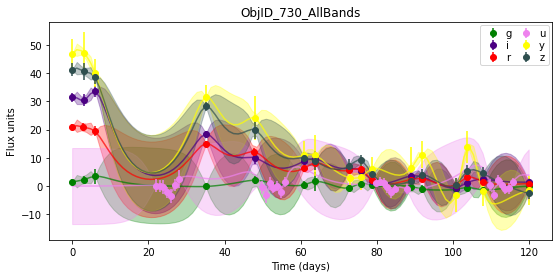

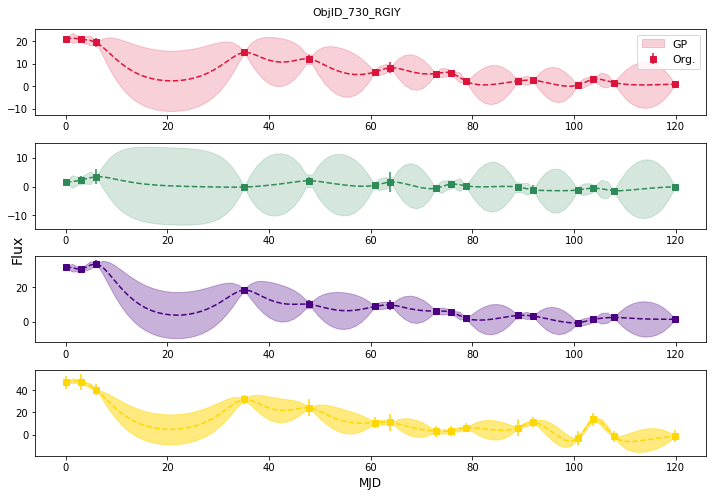

In [8]:
################################
# check for a particular object ID
################################

obj_id = object_list[2]

GP_class_init = GP_for_transient(input_df=training, obj_id=obj_id)

obs_transient = GP_class_init.shift_time()

x_dates_dict, y_dict, y_err_dict = return_flux_w_err(obs_transient)

obj_gps = GP_class_init.gp_fit_predict()
obj_gps = GP_class_init.pred_gp_fl_final()




x_dates_dict_gp, y_dict_gp, y_err_dict_gp = return_flux_w_err(obj_gps)

##################################
# final plot for original and GP
##################################
plot_real_data_and_model(obs_transient, obj_id, obj_model=obj_gps)

plot_4_bands_w_GP(x_dates_dict, x_dates_dict_gp, y_dict, y_dict_gp, y_err_dict, y_err_dict_gp, obj_id)

### Try For Another Object

/home/sbhattacharyya/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
/home/sbhattacharyya/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


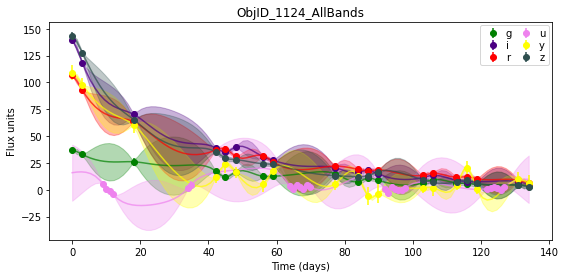

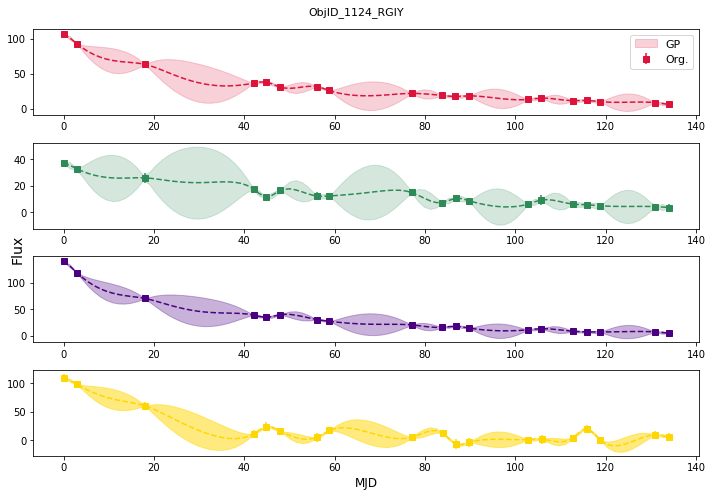

In [9]:
################################
# check for a particular object ID
################################

obj_id = object_list[4]

GP_class_init = GP_for_transient(input_df=training, obj_id=obj_id)

obs_transient = GP_class_init.shift_time()

x_dates_dict, y_dict, y_err_dict = return_flux_w_err(obs_transient)

obj_gps = GP_class_init.gp_fit_predict()
obj_gps = GP_class_init.pred_gp_fl_final()




x_dates_dict_gp, y_dict_gp, y_err_dict_gp = return_flux_w_err(obj_gps)

##################################
# final plot for original and GP
##################################
plot_real_data_and_model(obs_transient, obj_id, obj_model=obj_gps)

plot_4_bands_w_GP(x_dates_dict, x_dates_dict_gp, y_dict, y_dict_gp, y_err_dict, y_err_dict_gp, obj_id)